In [3]:
import pandas as pd
import numpy as np

In [4]:
df_kappa = pd.read_csv('../csv/kappa.0.dat', delim_whitespace=True, header=None)
df_kappa.columns = ['Temperature_Index', 'Pressure_Index', 'Opacity_Value']
df_kappa.tail(40)

/tmp/ipykernel_101025/1420512841.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_kappa = pd.read_csv('../csv/kappa.0.dat', delim_whitespace=True, header=None)


,Temperature_Index,Pressure_Index,Opacity_Value
1136,54,2,0.001000
1137,54,3,0.001006
1138,54,4,0.001022
1139,54,5,0.001074
1140,54,6,0.001236
1141,54,7,0.001750
1142,54,8,0.003351
1143,54,9,0.008442
1144,54,10,0.024523
1145,54,11,0.074457


In [5]:
# Define the grid and convert the third column into a 2D array
xg = df_kappa['Temperature_Index'].unique()
yg = df_kappa['Pressure_Index'].unique()
grid = df_kappa.pivot(index='Pressure_Index', columns='Temperature_Index', values='Opacity_Value').values

X, Y = np.meshgrid(xg, yg)

print("xg:", xg.shape)
print("yg:", yg.shape)
print("grid shape:", grid.shape)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Check if the grid and meshgrid arrays have the same shape
assert grid.shape == X.shape == Y.shape, "The grid and meshgrid arrays do not have the same shape"

xg: (56,)
yg: (21,)
grid shape: (21, 56)
X shape: (21, 56)
Y shape: (21, 56)


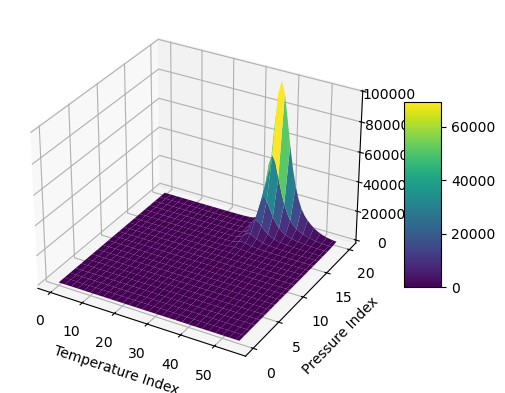

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
# Plot the surface
surf = ax.plot_surface(X, Y, grid, cmap='viridis')

# Plot the contour where the minima is found
min_value = np.min(grid)
min_indices = np.where(grid == min_value)
ax.contour(X, Y, grid, levels=[min_value], colors='r', linestyles='dashed')

ax.set_xlabel('Temperature Index')
ax.set_ylabel('Pressure Index')
ax.set_zlabel('Opacity Value')

# Add a colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

In [ ]:
from scipy.interpolate import griddata

# Define the new grid points
xg_new = np.linspace(xg.min(), xg.max(), 100)
yg_new = np.linspace(yg.min(), yg.max(), 100)
X_new, Y_new = np.meshgrid(xg_new, yg_new)

# Interpolate the grid data
points = np.array([X.flatten(), Y.flatten()]).T
values = grid.flatten()
grid_new = griddata(points, values, (X_new, Y_new), method='cubic')

print("New grid shape:", grid_new.shape)